In [1]:
import pandas
import datetime
import feather
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,5,16)
timeStart = datetime.datetime(2011,5,16,7,0)
timeEnd = datetime.datetime(2011,5,16,10,0)
sapsTime = datetime.datetime(2011,5,16,8,20)
sapsRadList = [ "cvw" ]
sapsMlatRange = [ 56., 60. ]
sapsVelCutoff = 25.
sapsNpointsCutoff = 50 # per radar per beam

In [3]:
# read from the feather file
velsDF = feather.read_dataframe('../data/saps-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
velsDF.head()

,dateStr,timeStr,beam,range,azimCalcMag,vLos,MLAT,MLON,MLT,GLAT,GLON,radId,radCode,date,normMLT
0,20110516,700,0,2,-2.9119,1.6006,40.1949,-144.9959,16.5659,45.3684,143.7537,40,hok,2011-05-16 07:00:00,-7.4341
1,20110516,700,0,3,-1.7818,2.0959,40.6224,-144.9279,16.5705,45.8067,143.8465,40,hok,2011-05-16 07:00:00,-7.4295
2,20110516,700,0,4,-0.9696,3.3891,41.0394,-144.8684,16.5744,46.2334,143.9308,40,hok,2011-05-16 07:00:00,-7.4256
3,20110516,700,0,5,-0.3545,2.5890,41.4503,-144.8143,16.5781,46.6531,144.0106,40,hok,2011-05-16 07:00:00,-7.4219
4,20110516,700,0,6,0.1277,-0.8005,41.8574,-144.7640,16.5814,47.0682,144.0876,40,hok,2011-05-16 07:00:00,-7.4186


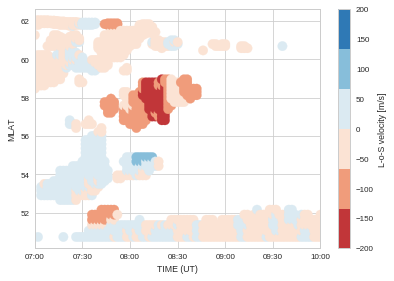

In [4]:
# sel data from a radar
rtiDF = velsDF[ (velsDF["radCode"] == "cvw") &\
              (velsDF["beam"] == 7) ]
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdBu"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiPlot = ax.scatter( rtiDF["date"].values, rtiDF["MLAT"].values,\
           c=rtiDF["vLos"].values, cmap=seaMap,vmin=-200, vmax=200, s=90. )
ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")
fig.savefig( "../plots/rtpy-sctr-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


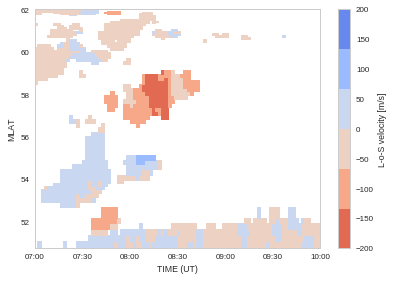

In [5]:
# sel data from a radar
rtiDF = velsDF[ (velsDF["radCode"] == "cvw") &\
              (velsDF["beam"] == 7) ]
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiDF["dtNum"] = [ date2num(x) for x in rtiDF["date"] ]
plotDF = rtiDF[ ["MLAT", "dtNum",\
                        "vLos"] ].pivot( "MLAT", "dtNum" )
mlatVals = plotDF.index.values
timeVals = plotDF.columns.levels[1].values

timeCntr, mlatCntr  = numpy.meshgrid( timeVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["vLos"].values),plotDF["vLos"].values)
rtiPlot = ax.pcolormesh(timeCntr, mlatCntr, vLosVals, cmap=seaMap, vmin=-200,vmax=200)


ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")
fig.savefig( "../plots/rtpy-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

In [6]:
# Filter SAPS scatter using the
# following criteria!!!
# 1) select the radars where SAPS
# is observed
sapsDF = velsDF[ velsDF["radCode"].isin(sapsRadList) ]
# 2) The flows are westward!
# So beams with negative azimuth will have
# negative LoS vels and vice-versa!
sapsDF = sapsDF[sapsDF["azimCalcMag"]/sapsDF["vLos"] > 0. ]
# 3) Set a MLAT limit
sapsDF = sapsDF[ (sapsDF["MLAT"] >= sapsMlatRange[0]) &\
               (sapsDF["MLAT"] <= sapsMlatRange[1]) ]
# 4) Set a velocity cutoff
sapsDF = sapsDF[ numpy.abs(sapsDF["vLos"]) >= sapsVelCutoff ]
# 5) Finally group by radar and beam number to
# discard velocities whose values are
cntPntsSAPSGrp = sapsDF.groupby( ["radCode", "beam"] ).size().reset_index()
cntPntsSAPSGrp.columns = ["radCode", "beam", "nPoints"]
sapsDF = pandas.merge( sapsDF, cntPntsSAPSGrp, on=["radCode", "beam"] )
sapsDF = sapsDF[ sapsDF["nPoints"] >= sapsNpointsCutoff ]

194


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


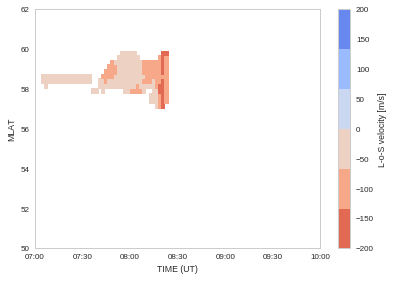

In [11]:
# sel data from a radar and beam
rtiDF = sapsDF[ (sapsDF["radCode"] == "cvw") &\
               (sapsDF["beam"] == 9) ]
print len(rtiDF.index)
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiDF["dtNum"] = [ date2num(x) for x in rtiDF["date"] ]
plotDF = rtiDF[ ["MLAT", "dtNum",\
                        "vLos"] ].pivot( "MLAT", "dtNum" )
mlatVals = plotDF.index.values
timeVals = plotDF.columns.levels[1].values

timeCntr, mlatCntr  = numpy.meshgrid( timeVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["vLos"].values),plotDF["vLos"].values)
rtiPlot = ax.pcolormesh(timeCntr, mlatCntr, vLosVals, cmap=seaMap, vmin=-200,vmax=200)


ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_ylim( [50,62] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")
fig.savefig( "../plots/rt-saps-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

In [8]:
# Get l-shell fitted velocities from
# the SAPS vLos at different time intervals
lshellDF = sapsDF[ sapsDF["date"] == sapsTime ]
lshellDF["beam"].unique()

array([12, 13,  9, 10,  5, 20, 21, 22, 23,  8,  7, 11,  6])

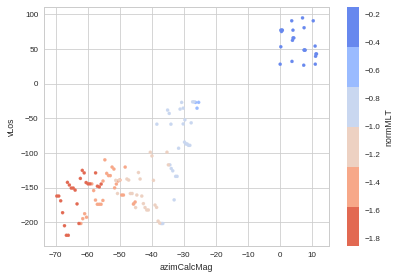

In [9]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
lshellDF.plot( kind='scatter',
              x='azimCalcMag',
              y='vLos',
              c='normMLT',
              s=10., cmap=seaMap, ax=ax)
fig1.savefig("../plots/lshell-test.pdf",bbox_inches='tight')